# Network Flow Approximation Model

### Import utils

In [5]:
from util_functions import *

### Import dataset and train model

In [6]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

def flatten_matrices(matrices):
    flattened = [matrix.flatten() for matrix in matrices]
    return np.array(flattened)

adjacency_matrices = load_data_from_pickle('./data/adjacency_matrices.pickle')
optimized_matrices = load_data_from_pickle('./data/optimized_matrices.pickle')

X = flatten_matrices(adjacency_matrices)
y = flatten_matrices(optimized_matrices)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

In [3]:
class Network(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Network(input_dim, output_dim).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_data = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
train_loader = DataLoader(train_data, batch_size=32)

n_epochs = 100
for epoch in range(n_epochs):

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

def evaluate_loss(dataset):
    data_loader = DataLoader(TensorDataset(torch.FloatTensor(dataset[0]), torch.FloatTensor(dataset[1])),
                             batch_size=32)
    total_loss = 0.0
    data_points = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            data_points += inputs.size(0)
    return total_loss / data_points

In [4]:
train_loss = evaluate_loss((X_train, y_train))
test_loss = evaluate_loss((X_test, y_test))

print('Train Loss:', train_loss)
print('Test Loss:', test_loss)

Train Loss: 0.0069015510175933145
Test Loss: 0.01565851077664119


### Test model on newly generated matrix

In [5]:
def predict_optimized_matrix(model, adjacency_matrix):
    original_shape = adjacency_matrix.shape
    flat_matrix = adjacency_matrix.flatten()

    # Convert the flat_matrix to a PyTorch tensor and pass it to the model
    flat_matrix_tensor = torch.FloatTensor(flat_matrix).to(device).unsqueeze(0)
    with torch.no_grad():
        predicted_flat_optimized_matrix = model(flat_matrix_tensor).detach().cpu().numpy()

    # Reshape the predicted_flat_optimized_matrix back to the original shape
    predicted_optimized_matrix = predicted_flat_optimized_matrix.reshape(original_shape)
    return predicted_optimized_matrix

In [24]:
graph, source, sink = generate_source_sink_network_graph(max_vertex_count, max_edge_count)
predicted_optimized_matrix = predict_optimized_matrix(model, graph)
predicted_optimized_matrix_rounded = round_down_small_values(predicted_optimized_matrix)
real_flow, optimized_graph = ford_fulkerson_optimized_graph(graph, source, sink)
#print_matrices(graph, optimized_graph, predicted_optimized_matrix, predicted_optimized_matrix_rounded)

In [25]:
predicted_flow = get_max_flow(predicted_optimized_matrix, 0, 4)
flow_difference = abs(real_flow - predicted_flow)/ real_flow
print_flow_comparison(predicted_flow, real_flow, flow_difference)

Predicted Flow: 10.081509590148926
Real Flow: 10.0
Difference: 0.008150959014892578
Accuracy: 0.9918490409851074


Original Graph


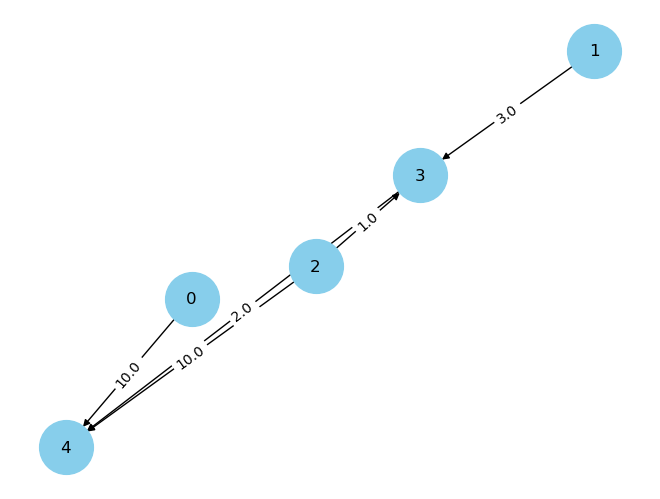

Optimized Graph


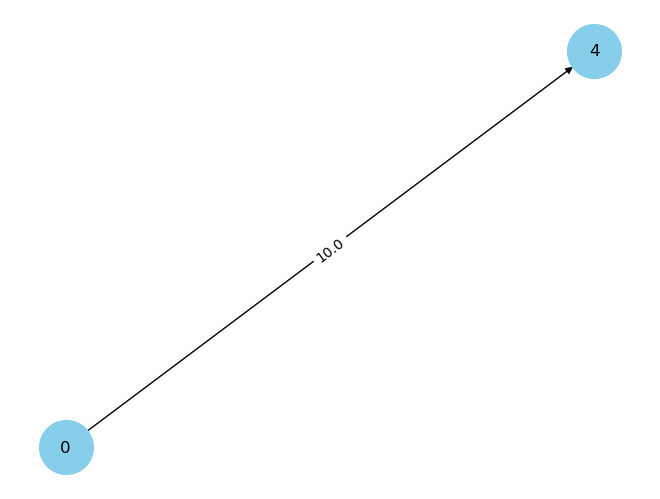

Predicted Optimized Graph (Rounded)


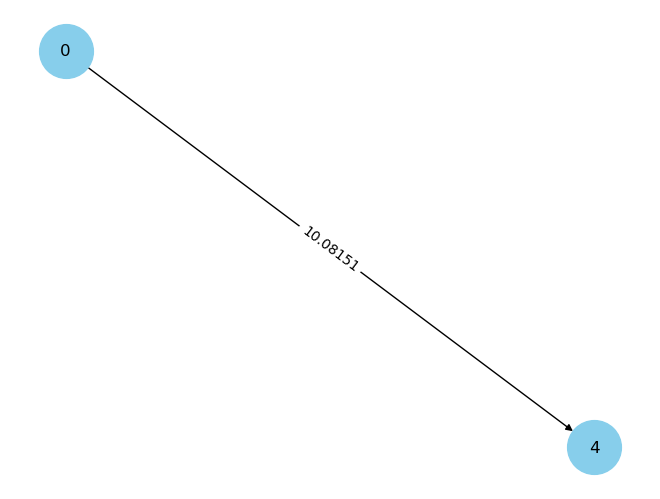

Predicted Optimized Graph (Raw)


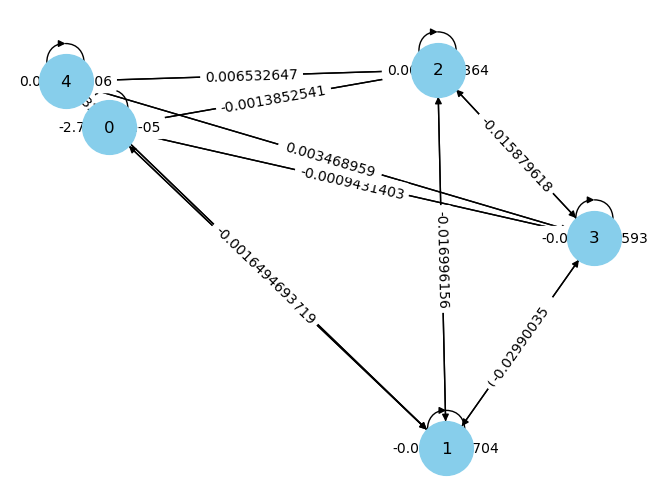

In [28]:
print_graph_comparison(graph, optimized_graph, round_down_small_values(predicted_optimized_matrix), predicted_optimized_matrix)